Link al repositorio de Github: https://github.com/100461170/AA_practica_1_grupo_10

Para subir los archivos y demás a lo largo de los diferentes cuadernos hemos estado usando Drive ya que es muy rápido y cómodo, en vez de subir los archivos manualmente

Autores: Alejandro Díaz Cuéllar 100472173 y Tomás Mendizábal 100461170

# **1.- Mini-análisis usando el modelo final**

In [ ]:
from google.colab import files
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# Si quieres subir el archivo wind_ava.csv desde tu ordenador
#uploaded = files.upload()

# Montar el drive para incluir el archivo desde ahí
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from sklearn.model_selection import TimeSeriesSplit
import re

# Estos son datos que vamos a usar para todos los modelos
df = pd.read_csv("/content/drive/MyDrive/AA_P1_Grupo10/wind_ava.csv")

patron = r'.*\.13$'
columnas_a_mantener = []
for column in df.columns:
  if column == "datetime" or column == "energy":
    columnas_a_mantener.append(column)
  if re.match(patron, column):
    columnas_a_mantener.append(column)
df = df[columnas_a_mantener]

columnas_a_eliminar = ['energy', 'datetime', 'p55.162.13', 'stl4.13', 'cape.13']
y = df['energy']
X = df.drop(columns=columnas_a_eliminar)
tscv = TimeSeriesSplit(n_splits=3)

Vamos ahora a comprobar si los resultados obtenidos utilizando nuestro mejor modelo son peores cuando intentamos predecir valores cada vez más altos

In [ ]:
from joblib import load
import numpy as np
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

modelo_svm = load('/content/drive/MyDrive/AA_P1_Grupo10/modelo_final.pkl')
y_pred = cross_val_predict(modelo_svm, X, y, cv=3)

# Calcular el error para las instancias donde el valor verdadero es mayor a 1000
error_mayor_1000 = mean_squared_error(y[y > 1000], y_pred[y > 1000])

# Calcular el error para las instancias donde el valor verdadero es menor o igual a 1000
error_menor_igual_1000 = mean_squared_error(y[y <= 1000], y_pred[y <= 1000])

# Comparar los porcentajes de error
print("Error para valores menores o iguales a 1000:", np.sqrt(error_menor_igual_1000))
print("Error para valores mayores a 1000:", np.sqrt(error_mayor_1000))

Error para valores menores o iguales a 1000: 277.27710276104494
Error para valores mayores a 1000: 550.7847738015885


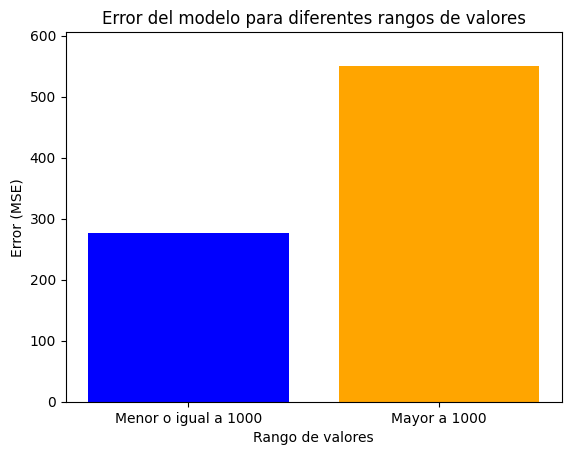

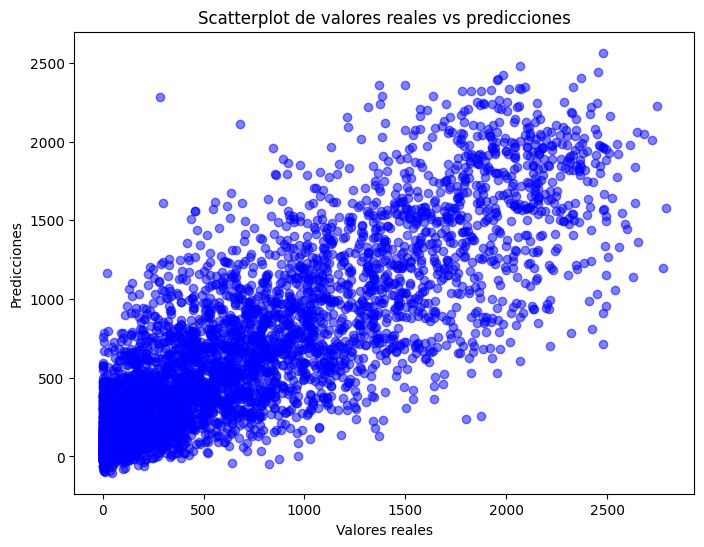

In [ ]:
errores = [np.sqrt(error_menor_igual_1000), np.sqrt(error_mayor_1000)]
conjuntos = ['Menor o igual a 1000', 'Mayor a 1000']

# Crear un gráfico de barras
plt.bar(conjuntos, errores, color=['blue', 'orange'])
plt.xlabel('Rango de valores')
plt.ylabel('Error (MSE)')
plt.title('Error del modelo para diferentes rangos de valores')
plt.ylim(0, max(errores) * 1.1)  # Ajusta el límite superior del eje y para dar espacio a las etiquetas

plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(y, y_pred, alpha=0.5, color='b')

# Añadir etiquetas y título
plt.title('Scatterplot de valores reales vs predicciones')
plt.xlabel('Valores reales')
plt.ylabel('Predicciones')

plt.show()


Como vemos, es claro que cuanto más alto es el valor real a predecir más dispersión del error hay, y por tanto el error es mayor, le cuesta mucho más predecir un valor cercano al real

# **2.- Conversión a un problema de clasificación**

Ahora vamos a convertir el problema en uno de clasificación utilizando para ello el tercer cuantil como valor divisorio entre las nuevas clases 'alta' y 'baja'

In [ ]:
# Calculamos el tercer cuantil
tercer_cuantil = np.percentile(y, 75)
print("Tercer cuantil:", tercer_cuantil)
# Creamos la nueva y
new_y = np.where(y > tercer_cuantil, 'alta', 'baja')

Tercer cuantil: 1089.375


# **3.- Entrenamiento de modelos**

In [ ]:
knn_scores = {}
trees_scores = {}
regr_scores = {}
svm_scores = {}

Vamos a crearnos nuestras propias métricas ya que cross_validation en scikit-learn no permite utilizar algunas de ellas por defecto en cross_val_score

In [ ]:
from sklearn.metrics import make_scorer, recall_score, balanced_accuracy_score, accuracy_score

def balanced_accuracy(y_true, y_pred):
    accuracy = balanced_accuracy_score(y_true, y_pred)
    return accuracy

def recall(y_true, y_pred):
  recall = recall_score(y_true, y_pred, pos_label='alta')
  return recall

def tnr(y_true, y_pred):
  tnr = recall_score(y_true, y_pred, pos_label='baja')
  return tnr

def accuracy(y_true, y_pred):
  accuracy = accuracy_score(y_true, y_pred)
  return accuracy

balanced_accuracy_scorer = make_scorer(balanced_accuracy)
recall_scorer = make_scorer(recall)
tnr_scorer = make_scorer(tnr)
accuracy_scorer = make_scorer(accuracy)

scorers = {'balanced_accuracy': balanced_accuracy_scorer, 'recall': recall_scorer, 'TNR': tnr_scorer, 'accuracy': accuracy_scorer}


## 3.1 - KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import RobustScaler

param_grid = {
    'kneighborsclassifier__n_neighbors': list(range(2, 30, 2)),
    'kneighborsclassifier__weights': ['uniform', 'distance'],
    'kneighborsclassifier__metric': ['euclidean', 'manhattan', 'chebyshev'],
    'kneighborsclassifier__p': [1, 2]  # Solo se aplica si se usa la distancia de Minkowski
}
knn_model_hpo = make_pipeline(RobustScaler(), KNeighborsClassifier())

# Hacemos nested cross validation
# Hacemos la evaluacion inner usando un RandomizedSearch con un budget de 20
regr = RandomizedSearchCV(estimator=knn_model_hpo, param_distributions=param_grid,
                                   n_iter=20, scoring=balanced_accuracy_scorer,
                                   cv=tscv, random_state=42)

regr.fit(X, new_y)
#print("Best params", regr.best_params_)

# Hacemos la outer evaluation
knn_scores_hpo = cross_validate(regr, X, new_y, scoring=scorers, cv = tscv)

for scorer_name, scorer_values in knn_scores_hpo.items():
    print(f"Promedio para {scorer_name}:", scorer_values.mean())
    knn_scores[scorer_name] = scorer_values.mean()


Promedio para fit_time: 2.013435204823812
Promedio para score_time: 0.11655243237813313
Promedio para test_balanced_accuracy: 0.7963079796494764
Promedio para test_recall: 0.7063965794598256
Promedio para test_TNR: 0.8862193798391272
Promedio para test_accuracy: 0.8407750631844988


## 3.2 - Árboles de decisión

In [ ]:
from scipy.stats import randint as sp_randint
from sklearn import tree

tree_hpo = tree.DecisionTreeClassifier(random_state=42, class_weight="balanced")

param_grid = {'max_depth': sp_randint (1, 16),
              'min_samples_split': sp_randint (2, 40),
              'min_samples_leaf': sp_randint (1, 20)}
regr = RandomizedSearchCV(estimator=tree_hpo, param_distributions=param_grid,
                                   n_iter=20, scoring=balanced_accuracy_scorer,
                                   cv=tscv, random_state=42)

regr.fit(X, new_y)
# print("Best params", regr.best_params_)

tree_scores_hpo = cross_validate(regr,
                            X, new_y,
                            scoring=scorers,
                            cv = tscv)

for scorer_name, scorer_values in tree_scores_hpo.items():
    print(f"Promedio para {scorer_name}:", scorer_values.mean())
    trees_scores[scorer_name] = scorer_values.mean()


Promedio para fit_time: 1.2429951032002766
Promedio para score_time: 0.009693384170532227
Promedio para test_balanced_accuracy: 0.8016373483217095
Promedio para test_recall: 0.755485747919287
Promedio para test_TNR: 0.847788948724132
Promedio para test_accuracy: 0.8239258635214828


## 3.3 - Regresión logística

In [ ]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import loguniform
import warnings

log_reg_hpo = make_pipeline(RobustScaler(), LogisticRegression(max_iter=1000, class_weight="balanced"))

param_grid = {#'logisticregression__penalty': ['l2', None],
              'logisticregression__C': np.logspace(-4, 4, 20)}

regr = RandomizedSearchCV(estimator=log_reg_hpo, param_distributions=param_grid,
                                   n_iter=20, scoring=balanced_accuracy_scorer,
                                   cv=tscv, random_state=42)
regr.fit(X, new_y)
# print("Best params", regr.best_params_)

log_reg_hpo_scores = cross_validate(regr, X, new_y, cv=tscv, scoring=scorers)

for scorer_name, scorer_values in log_reg_hpo_scores.items():
    print(f"Promedio para {scorer_name}:", scorer_values.mean())
    regr_scores[scorer_name] = scorer_values.mean()


Promedio para fit_time: 2.729024569193522
Promedio para score_time: 0.016057491302490234
Promedio para test_balanced_accuracy: 0.7183496722148704
Promedio para test_recall: 0.7235088691060917
Promedio para test_TNR: 0.7131904753236494
Promedio para test_accuracy: 0.7149677057006459


## 3.4 - SVM


In [ ]:
from sklearn.svm import SVC


svm_reg_hpo = make_pipeline(RobustScaler(), SVC(class_weight="balanced"))

param_grid = {'svc__C': loguniform(2**-5, 2**15),
                'svc__gamma': loguniform(2**-15, 2**3)}

regr = RandomizedSearchCV(estimator=svm_reg_hpo, param_distributions=param_grid,
                                   n_iter=20, scoring=balanced_accuracy_scorer,
                                   cv=tscv, random_state=42)

regr.fit(X, new_y)
# print("Best params", regr.best_params_)

svm_hpo_scores = cross_validate(regr, X, new_y, cv=tscv, scoring=scorers)

for scorer_name, scorer_values in svm_hpo_scores.items():
    print(f"Promedio para {scorer_name}:", scorer_values.mean())
    svm_scores[scorer_name] = scorer_values.mean()


Promedio para fit_time: 6.302693764368693
Promedio para score_time: 0.0634142557779948
Promedio para test_balanced_accuracy: 0.8306808179864947
Promedio para test_recall: 0.8307971025580606
Promedio para test_TNR: 0.830564533414929
Promedio para test_accuracy: 0.830103903397922


## 3.5 - Dummy Classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_score


# Crear el modelo DummyRegressor que predice la media
dummy_model = DummyClassifier(strategy="most_frequent")

# Realizar la validación cruzada
dummy_scores = cross_val_score(dummy_model, X, new_y, cv=2, scoring=balanced_accuracy_scorer)
print("Error del modelo dummy:", dummy_scores.mean())

Error del modelo dummy: 0.5


Como vemos, el balanced_accuracy del modelo Dummy es 0.5, lo que nos indica que la métrica se está realizando de manera correcta

# **4.- Selección del mejor modelo**

                             KNN       SVM     Trees      Regr
fit_time                2.013435  6.302694  1.242995  2.729025
score_time              0.116552  0.063414  0.009693  0.016057
test_balanced_accuracy  0.796308  0.830681  0.801637  0.718350
test_recall             0.706397  0.830797  0.755486  0.723509
test_TNR                0.886219  0.830565  0.847789  0.713190
test_accuracy           0.840775  0.830104  0.823926  0.714968


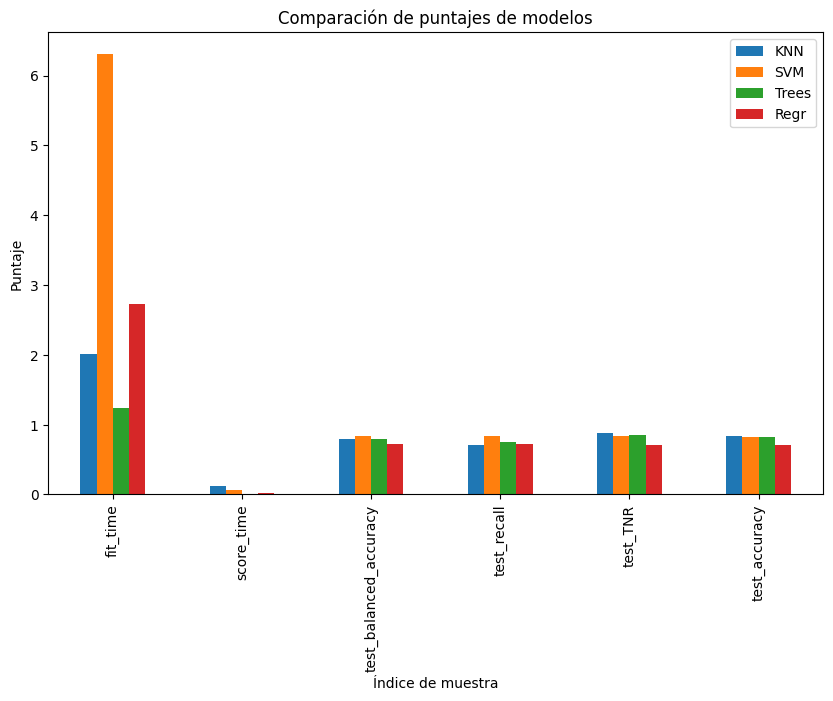

In [ ]:
df = pd.DataFrame([knn_scores, svm_scores, trees_scores, regr_scores])
df = df.T
df.columns = ['KNN', 'SVM', 'Trees', 'Regr']
print(df)

# Graficar
df.plot(kind='bar', figsize=(10, 6))
plt.title('Comparación de puntajes de modelos')
plt.xlabel('Índice de muestra')
plt.ylabel('Puntaje')
plt.show()

Como podemos comprobar mediante la tabla y los gráficos vemos que los 4 modelos son bastante parecidos en los puntajes. Nos vamos a centrar especificamente en balanced_accuracy ya que el problema inicial está desbalanceado y solo se ha podido balancear de manera específica en algunos de los modelos. Como vemos el modelo que mejor rendimiento tiene es SVM, con un 83% de balanced accuracy.

Por tanto creo que podemos concluir que el problema de clasificación tiene una solución mucho más satisfactoria que el de regresión, que tenía un error mucho más elevado en comparación.